<a href="https://colab.research.google.com/github/sfmajors373/FourthBrainBreastCancer/blob/seg_UNet_update/V2_SIMPLE_UNET_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script use a different data loading method

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Load the libraries
import numpy as np
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, UpSampling2D
from keras.layers.merge import concatenate
from tensorflow.nn import local_response_normalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import math
import pickle
from datetime import datetime
from numba import cuda 

%matplotlib inline

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
dim_tiles = 256
depth = 3

In [6]:
def unet(layer_in = Input(shape=(dim_tiles, dim_tiles, depth))):
    inputs = layer_in
    
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal',dilation_rate=2)(inputs) #dilation_rate=2 etc.
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal',dilation_rate=2)(conv1) #dilation_rate=2 etc.
    # conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    # conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    # conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    # conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    # conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5) 

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8) 

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid', name = 'feature')(conv9)

    flat10 = Flatten()(conv10)
    dense10 = Dense(1024, activation='sigmoid')(flat10)
    result = Dense(1, activation='softmax')(dense10)
    model = Model(inputs = inputs, outputs = result)
    return model

In [7]:
model = unet()

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
HDF5_FOLDER = '/content/drive/MyDrive/Colab Notebooks/CancerMap/train'

In [10]:
# Mannual Data Loading Methods
import h5py
import os

cancer_image = []
cancer_label = []
cancer_mask = []

file = os.listdir(HDF5_FOLDER)
for f_index in range(0, len(file)):
  if file[f_index].find('.hdf5') != -1:
    filepath = HDF5_FOLDER+'/'+file[f_index]

    f = h5py.File(filepath, 'r')
    f_name = list(f.keys())
    dset = np.array(f[f_name[0]])
    dset=dset[:,0:256, 0:256, :]
    print(dset.shape)
    if file[f_index].find('mask') != -1:
      cancer_mask.append(dset)
    elif file[f_index].find('normal') != -1:
      # cancer_label.append(0)
      # cancer_image.append(dset)
      labels = [0]*len(dset)

      if f_index == 0:
        cancer_image = dset
        cancer_label = labels
      else:
        cancer_image= np.concatenate((cancer_image, dset), axis = 0)
        cancer_label = np.concatenate((cancer_label, labels), axis = 0)
    else:
      labels = [1]*len(dset)
      if f_index == 0:
        cancer_image = dset
        cancer_label = labels
      else:
        cancer_image= np.concatenate((cancer_image, dset), axis = 0)
        cancer_label = np.concatenate((cancer_label, labels), axis = 0)

# print(cancer_image)
# print(cancer_label)
# print(cancer_mask)

(5, 256, 256, 3)
(5, 256, 256, 1)
(25, 256, 256, 3)
(25, 256, 256, 1)
(126, 256, 256, 3)
(268, 256, 256, 3)
(80, 256, 256, 3)
(179, 256, 256, 3)
(59, 256, 256, 3)
(215, 256, 256, 3)
(118, 256, 256, 3)
(225, 256, 256, 3)
(323, 256, 256, 3)
(140, 256, 256, 3)
(161, 256, 256, 3)
(295, 256, 256, 3)
(102, 256, 256, 3)
(159, 256, 256, 3)
(599, 256, 256, 3)
(4, 256, 256, 3)
(22, 256, 256, 3)
(22, 256, 256, 1)
(570, 256, 256, 3)
(143, 256, 256, 3)
(143, 256, 256, 1)
(570, 256, 256, 1)
(5, 256, 256, 1)
(48, 256, 256, 3)
(48, 256, 256, 1)
(7, 256, 256, 3)
(7, 256, 256, 1)
(112, 256, 256, 3)
(112, 256, 256, 1)
(35, 256, 256, 3)
(35, 256, 256, 1)
(1, 256, 256, 3)
(1, 256, 256, 1)
(33, 256, 256, 3)
(33, 256, 256, 1)
(2, 256, 256, 3)
(2, 256, 256, 1)
(57, 256, 256, 3)
(57, 256, 256, 1)
(546, 256, 256, 1)
(33, 256, 256, 1)
(33, 256, 256, 3)
(546, 256, 256, 3)
(88, 256, 256, 3)
(88, 256, 256, 1)
(4, 256, 256, 1)
(5, 256, 256, 3)
(77, 256, 256, 1)
(57, 256, 256, 1)
(57, 256, 256, 3)
(38, 256, 256, 3)
(

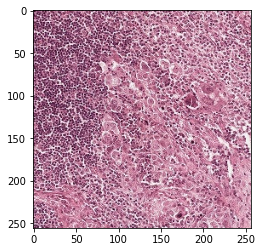

In [11]:
test = cancer_image[0]
test = tf.squeeze(test)
test.shape
plt.imshow(test)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cancer_image, cancer_label, test_size = 0.2, random_state = 42)

In [13]:
batch_size=30
batches_per_train_epoch = 10
batches_per_val_epoch = 10
MAX_EPOCHS = 40

In [14]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, batch_size=10, epochs=40,validation_split=0.2) 

Epoch 1/40
512/512 [==============================] - 422s 798ms/step - loss: 0.0000e+00 - accuracy: 0.6302 - val_loss: 0.0000e+00 - val_accuracy: 0.6273
Epoch 2/40
512/512 [==============================] - 405s 791ms/step - loss: 0.0000e+00 - accuracy: 0.6248 - val_loss: 0.0000e+00 - val_accuracy: 0.6273
Epoch 3/40
512/512 [==============================] - 403s 788ms/step - loss: 0.0000e+00 - accuracy: 0.6216 - val_loss: 0.0000e+00 - val_accuracy: 0.6273
Epoch 4/40
512/512 [==============================] - 404s 790ms/step - loss: 0.0000e+00 - accuracy: 0.6290 - val_loss: 0.0000e+00 - val_accuracy: 0.6273
Epoch 5/40
512/512 [==============================] - 404s 788ms/step - loss: 0.0000e+00 - accuracy: 0.6223 - val_loss: 0.0000e+00 - val_accuracy: 0.6273
Epoch 6/40
512/512 [==============================] - 404s 789ms/step - loss: 0.0000e+00 - accuracy: 0.6163 - val_loss: 0.0000e+00 - val_accuracy: 0.6273
Epoch 7/40
512/512 [==============================] - 404s 789ms/step - loss

In [ ]:
history = model.fit(train_data.generator(batch_size, True, green_layer_only=False, color_normalization_file=color_normalization_json),
                    validation_data=val_data.generator(batch_size, False, green_layer_only=False, color_normalization_file=color_normalization_json),
                    epochs=MAX_EPOCHS,
                    steps_per_epoch = batches_per_train_epoch,
                    validation_steps = batches_per_val_epoch)

File not accessible
Epoch 1/40
10/10 [==============================] - 35s 3s/step - loss: 0.0000e+00 - accuracy: 0.1460 - val_loss: 0.0000e+00 - val_accuracy: 0.1357
Epoch 2/40
10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00 - accuracy: 0.1683 - val_loss: 0.0000e+00 - val_accuracy: 0.1326
Epoch 3/40
10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00 - accuracy: 0.1246 - val_loss: 0.0000e+00 - val_accuracy: 0.1434
Epoch 4/40
10/10 [==============================] - 25s 3s/step - loss: 0.0000e+00 - accuracy: 0.1568 - val_loss: 0.0000e+00 - val_accuracy: 0.1488
Epoch 5/40
10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00 - accuracy: 0.1380 - val_loss: 0.0000e+00 - val_accuracy: 0.1406
Epoch 6/40
10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00 - accuracy: 0.1518 - val_loss: 0.0000e+00 - val_accuracy: 0.1435
Epoch 7/40
10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00 - accurac

In [ ]:
def plot_history(history):
  # This function will plot the model fit process
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


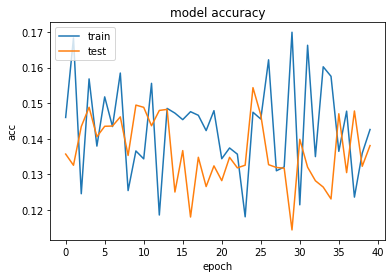

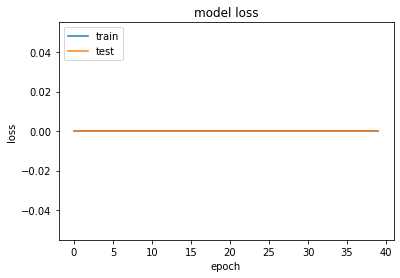

In [ ]:
plot_history(history)

In [ ]:
# Test Accuracy
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score
prediction_values = np.argmax(model.predict(X_test), axis=-1)
print(f'Accuracy = {accuracy_score(Y_test, prediction_values)}')
print(f'F1 = {f1_score(Y_test, prediction_values,average = None)}')
print(f'Precision = {precision_score(Y_test, prediction_values,average=None)}')
print(f'Recall = {recall_score(Y_test, prediction_values,average = None)}')
# Display the confusion matrix
print('Confusion matrix =')
print(confusion_matrix(Y_test, prediction_values))

NameError: ignored

In [ ]:
now1 = datetime.now()
model_type = 'unet'
model_hdf5 = '/media/nico/data/fourthbrain/project/model_testing/model_{}_'.format(model_type) + now1.strftime("%Y%m%d-%H%M%S") + '.hdf5'
filepath = '/media/nico/data/fourthbrain/project/model_testing/{}.pkl'.format(model_type)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_hdf5, monitor='loss',verbose=1, save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                           verbose=1, mode='max', min_lr=1e-5)

#all callbacks
callbacks = [tensorboard_callback, model_checkpoint, reduce_lr]        
history = model.fit(x=train_data.generator(batch_size_neg, batch_size_pos, True, green_layer_only=False, color_normalization_file=color_normalization_json),
                    validation_data=val_data.generator(batch_size_neg, batch_size_pos, False, green_layer_only=False, color_normalization_file=color_normalization_json),
                    epochs=MAX_EPOCHS,
                    steps_per_epoch = batches_per_train_epoch,
                    validation_steps = batches_per_val_epoch,
                    callbacks=callbacks
                   )
dtme = now1.strftime('%m%d%Y_%H%M%S.pkl')
now2 = datetime.now()
print('duration: {} - path: {}'.format(now2 - now1, filepath))
history_to_pickle(history, filepath)

/home/nico/miniconda3/envs/nightly/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: could not broadcast input array from shape (50,256,256,3) into shape (50,256,256)